In [1]:
import sys

sys.path.insert(1, '/Users/users/spirov/ThesisProject/Executable')

import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn
from NeuralNets import CustomVaexDataset, printNodes, sc, StraightNetwork,Unet,Stefann
from matplotlib import pyplot as plt

from torch.nn.modules.loss import _Loss



from DataCore import snapshotPath,L


from cycler import cycler




torch.set_default_dtype(torch.float64)

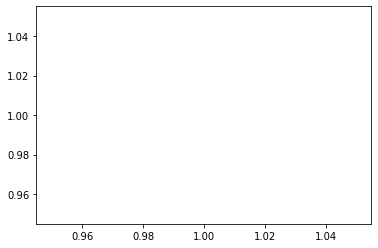

In [2]:


plt.plot([1],[1])

font = {"weight": "normal", "size": 14}
plt.rcParams["axes.linewidth"] = 1.5  # set the value globally
plt.rc("font", **font)
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
_legend = {"frameon": True, "framealpha":0.7}
plt.rc("legend", **_legend)
plt.rcParams["axes.prop_cycle"] = cycler("color",('indigo','b','r','k','#ff7f0e','g'))
plt.show()

# Model Maker

In [3]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)[0]
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 4 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: [{current:>5d}/{size:>5d}]  {loss:>7f}")

            
            
            
def snapshot(name=""):
    print("------------------")
    print("Autosave...")
    print("------------------")
    torch.save(model.state_dict(), snapshotPath)
    fig= plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.ylim(52,54)
    plt.plot(Ls, marker="+")
    plt.title("Loss")
    plt.subplot(122)
    plt.plot(Cs, marker="v")
    plt.title("Correctness")
    plt.suptitle(f"Snapshot {name}")
    fig.savefig('./Model Figures/Model State.png', dpi=fig.dpi)


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)[0]
            test_loss += loss_fn(pred, y).item()
            correct += ((pred - y).abs() < bmark).type(torch.float).sum().item()

    test_loss /= num_batches

    correct /= size * y.size()[1]
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    Ls.append(test_loss)
    Cs.append(correct)



In [4]:

batch_size = 64

p2 = "/Users/users/spirov/Blk/Nexus Project/Thesis-Project-Cosmic-Web/Data/Training/"
p3 = "/Users/users/spirov/Blk/Nexus Project/Thesis-Project-Cosmic-Web/Data/Testing/"


train_set = CustomVaexDataset(p2)
test_set = CustomVaexDataset(p3)


torch.set_default_dtype(torch.float64)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print("----------------------")
print(f"Using {device} device")
print("----------------------")




printNodes()



train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)





----------------------
Using cpu device
----------------------
----------------
335976 -> 32768 -> 111992
----------------


In [5]:
def scatterLossPrototype(output,target):
    loss1 = torch.mean((output - target)**2)
    tstd = target.std().item()
    ostd = output.std().item()
    
    loss2 = (tstd/ostd + ostd/tstd)/2 - 1
    
    loss = loss1 + loss2*3
    
    return loss

def bigLSE(output,target):
    
    p = 3
    
    loss = torch.mean(((output-target)**2)**p)
    
    return loss
    

def inverseXLSE(out,tar):
    
    x = (tar.max()/tar)**2
    
    p = 0.25
    
    loss = torch.mean(((out-tar)**2)*x*p)
    
    return loss
    
    
def ratioLoss(out,tar):
    
    outSafe = out + 1e-3
    
    l = outSafe/tar + tar/outSafe
    
    loss = l.abs().sum()
    
    return loss
    
    
    

    
    

# Using saved model

In [6]:
sc = 3.75e4

learning_rate = 1e-2 #sc/1e5
epochs = 40
bmark = 1e3/sc


In [7]:
GoodPath = "/Users/users/spirov/ThesisProject/Snapshots/EYOOOOOOO.pt"

model =Unet() #BottleneckNetwork() # StraightNetwork() #
model.load_state_dict(torch.load(GoodPath,map_location=torch.device('cpu')))

dataPath = "/Users/users/spirov/Blk/Nexus Project/Thesis-Project-Cosmic-Web/Data/Testing/"

dataset = CustomVaexDataset(dataPath)

img, label = dataset.__getitem__(0)

with torch.no_grad():
    mod = model(img.reshape(1,3,len(label)))





In [8]:
mod[0].shape

torch.Size([111992])

Text(0, 0.5, 'residual')

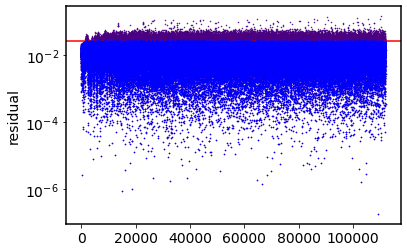

In [9]:
resid = (mod[0]-label).abs()

plt.plot(resid,marker='.',linestyle='',markersize=1)

plt.axhline(bmark,c='r')

filt = resid<(bmark)

plt.plot(np.arange(resid.size()[0])[filt],resid[filt],marker='.',linestyle='',markersize=1)

plt.yscale('log')
plt.ylabel("residual")


### 

Text(0.5, 0, 'residual')

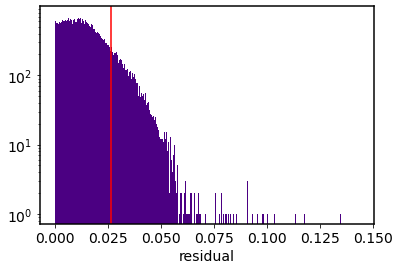

In [10]:
plt.hist(resid,1000)
plt.yscale('log')
plt.axvline(bmark,c='r')
plt.xlabel('residual')

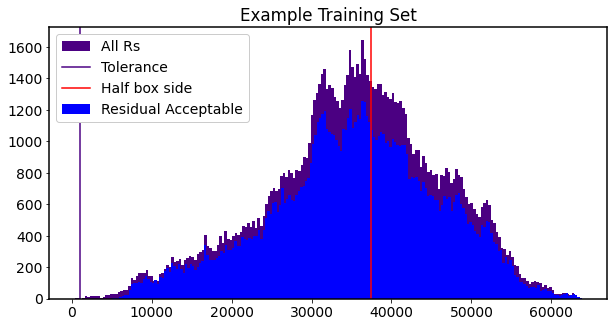

In [11]:
b = 200

plt.figure(figsize=(10,5))
plt.hist(label*sc,b,label='All Rs')
plt.axvline(1e3,label='Tolerance')
plt.axvline(3.75e4,c='r',label="Half box side")
plt.hist(label[filt]*sc,b,label='Residual Acceptable')

plt.legend(loc=2,framealpha=1)
plt.title("Example Training Set")
plt.show()

In [12]:
trus = label[filt].size()[0]
tot = label.size()[0]


print(trus/tot)

0.8589274233873848


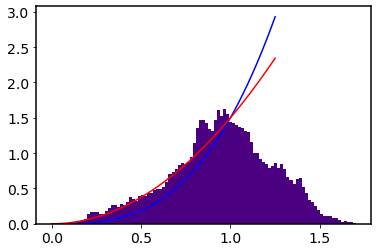

In [13]:
plt.hist(label,100,density=True)
x = np.linspace(0,1.25,50)
plt.plot(x,1.5*x**3)
plt.plot(x,1.5*x**2)

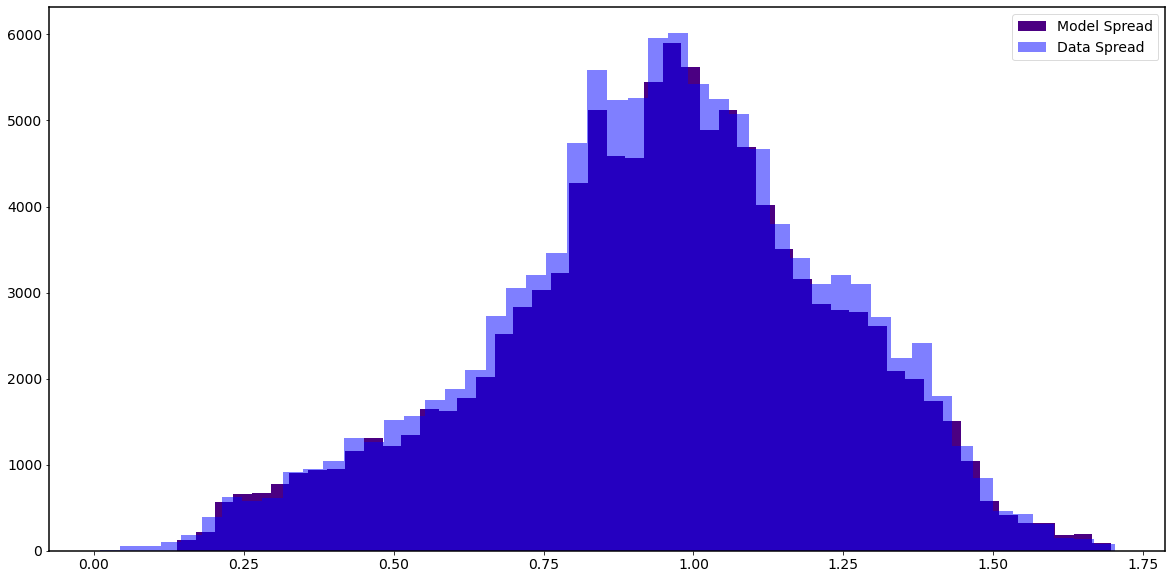

In [14]:
plt.figure(figsize=(20,10))
plt.hist(mod[0],50,label="Model Spread")
plt.hist(label,50,label="Data Spread",alpha=0.5)
plt.legend()
#plt.yscale("log")
plt.show()

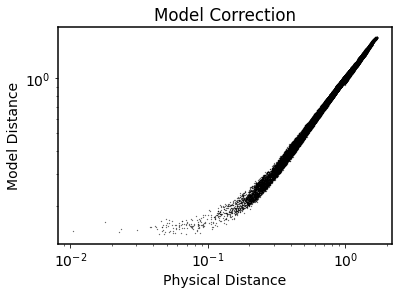

In [15]:
plt.loglog(label,mod[0],'k.',markersize=0.5)
plt.xlabel("Physical Distance")
plt.ylabel("Model Distance")
plt.title("Model Correction")
plt.show()

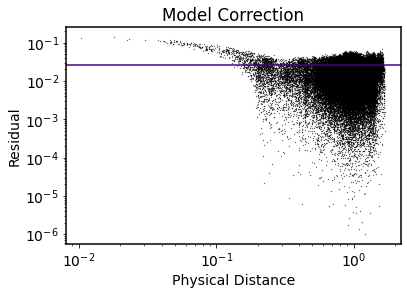

In [16]:
plt.loglog(label,mod[0]-label,'k.',markersize=0.5)
plt.xlabel("Physical Distance")
plt.ylabel("Residual")
plt.title("Model Correction")
plt.axhline(bmark)
plt.show()

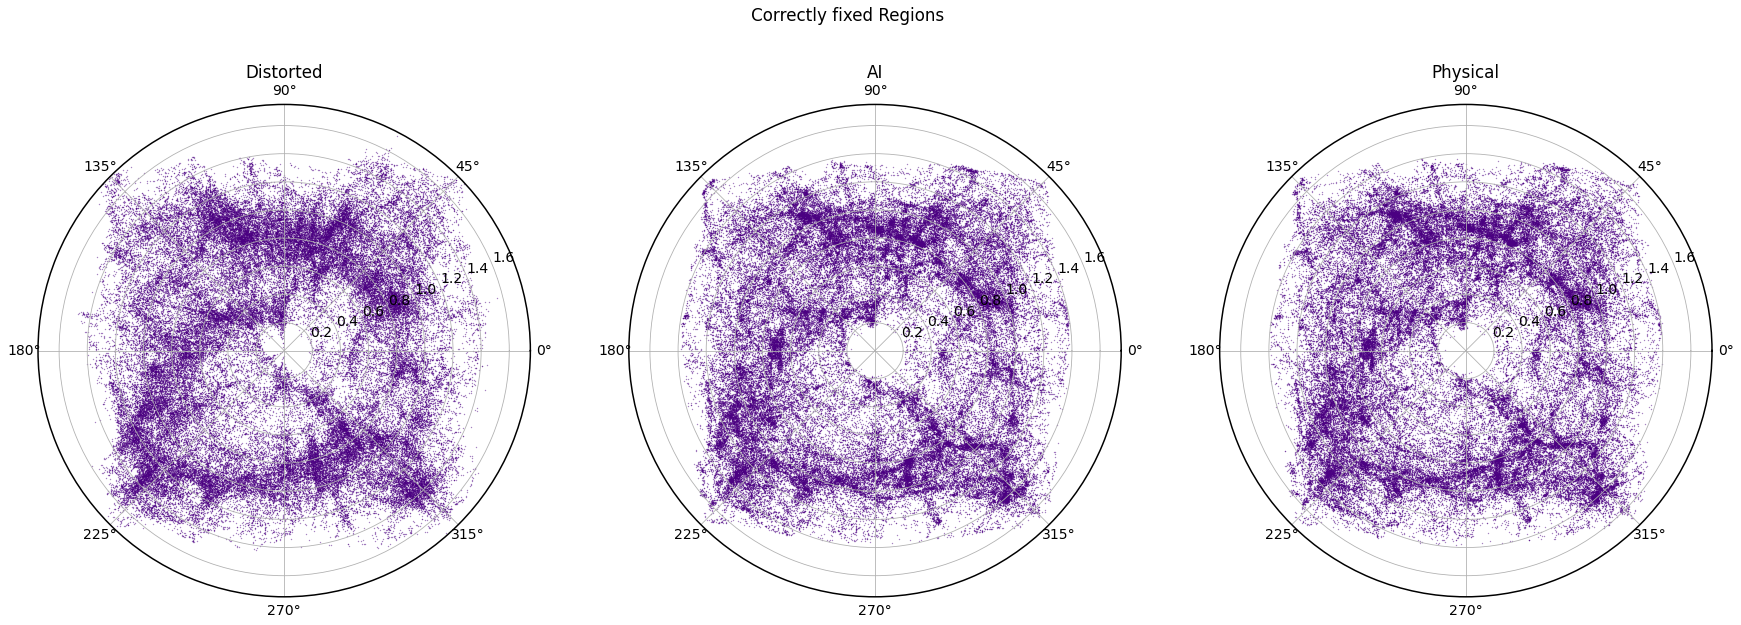

In [17]:
siz = .1

plt.figure(figsize=(30,10))
plt.subplot(131,projection="polar")
plt.ylim(0,1.75)
plt.scatter(img[2][filt],img[0][filt],s=siz,alpha=0.7)
plt.title("Distorted")
plt.subplot(132,projection="polar")
plt.ylim(0,1.75)
plt.scatter(img[2][filt],mod[0][filt],s=siz,alpha=0.7)
plt.title("AI")
plt.subplot(133,projection="polar")
plt.ylim(0,1.75)
plt.scatter(img[2][filt],label[filt],s=siz,alpha=0.7)
plt.title("Physical")

plt.suptitle("Correctly fixed Regions")
plt.show()

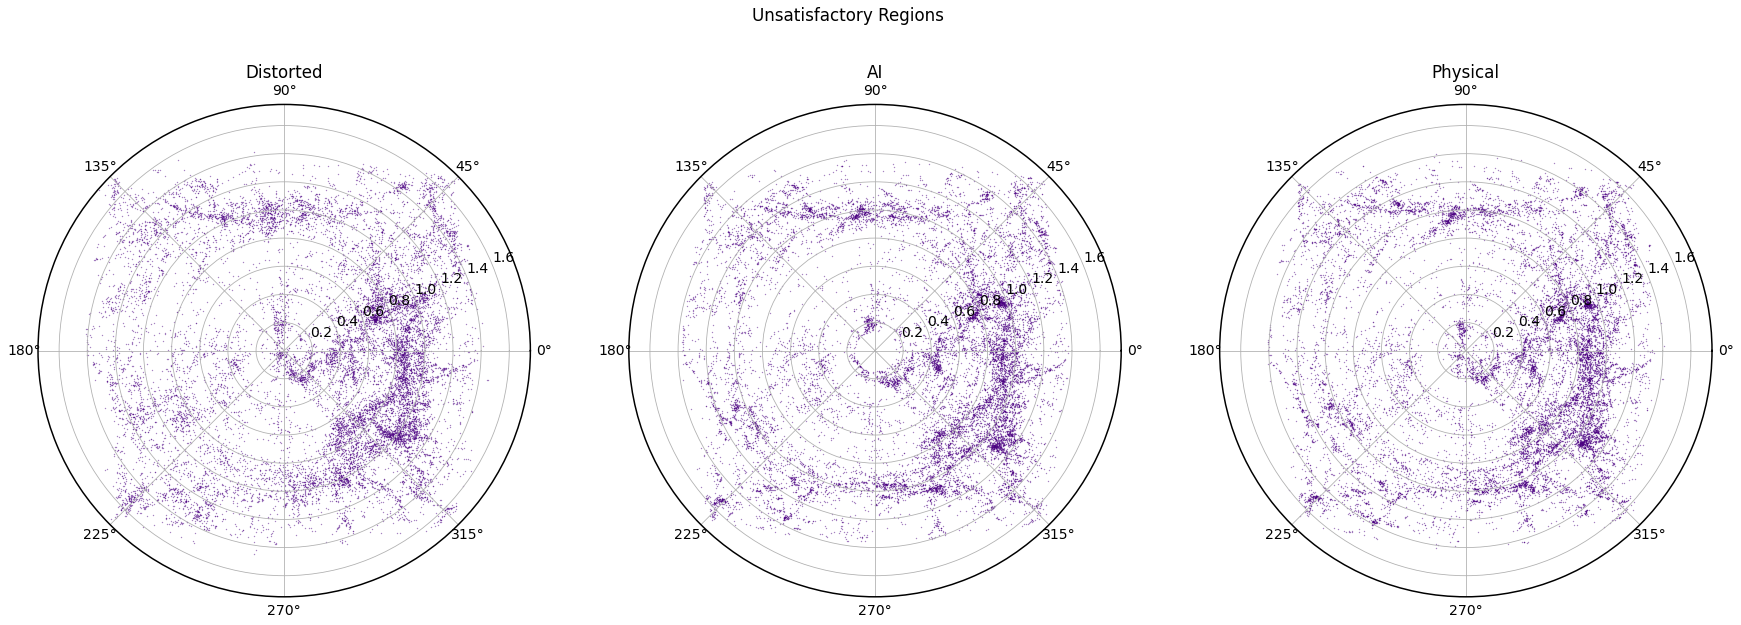

In [18]:
siz = .1

plt.figure(figsize=(30,10))
plt.subplot(131,projection="polar")
plt.ylim(0,1.75)
plt.scatter(img[2][~filt],img[0][~filt],s=siz,alpha=0.7)
plt.title("Distorted")
plt.subplot(132,projection="polar")
plt.ylim(0,1.75)
plt.scatter(img[2][~filt],mod[0][~filt],s=siz,alpha=0.7)
plt.title("AI")
plt.subplot(133,projection="polar")
plt.ylim(0,1.75)
plt.scatter(img[2][~filt],label[~filt],s=siz,alpha=0.7)
plt.title("Physical")

plt.suptitle("Unsatisfactory Regions")
plt.show()

In [19]:
A = []

correct = 0
N=len(dataset)
for i in range(N):
    
    img, label = dataset.__getitem__(i)
    with torch.no_grad():
        mod = model(img.reshape(1,3,len(label)))
        
    resid = (mod[0]-label).abs()
    filt = resid<(bmark)
    correct += ((label - mod[0]).abs() < bmark).type(torch.int).sum().item()
    acc = len(resid[filt])/len(resid)
    A.append(acc)
    if i%10 ==0:
        print(i)
correct /= N

0
10
20
30
40
50
60
70
80
90
100
110
120


In [20]:
correct/len(label)

0.7192208065085006

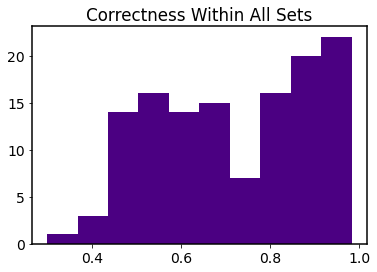

In [23]:
plt.hist(A,10)
plt.title("Correctness Within All Sets")
plt.show()